In [2]:
pip install transformers

     |████████████████████████████████| 675kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 14.8MB/s 
     |████████████████████████████████| 3.8MB 23.7MB/s 
     |████████████████████████████████| 890kB 26.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=fcbe0308a8018ea2cf73ebf1f7c4f7906fe8e86af97256f09e2b3fa86c1a1355
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
pip install emoji

     |████████████████████████████████| 51kB 2.0MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=f2be6ba38e741f51ed8a70665c93d0c76f8bd088392ee0e6698f4565fa5738f9
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import pandas as pd
import numpy as np
import torch
import transformers as ppb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import gensim.summarization
import emoji

In [5]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1bFYRBWjAqXFxrRnA6XGqRY2ffh6gsAgG'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('IMDB Dataset.csv') 
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,length of text,sentiment
0,Match 1: Tag Team Table Match Bubba Ray and Sp...,13704,positive
1,There's a sign on The Lost Highway that says:<...,12988,positive
2,"(Some spoilers included:)<br /><br />Although,...",12930,positive
3,"Back in the mid/late 80s, an OAV anime by titl...",12129,positive
4,**Attention Spoilers**<br /><br />First of all...,10363,positive


In [3]:
data.shape

(50000, 3)

In [6]:
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

We're gona tranform the sentiment into a dummy variable so the analysis will be easier

In [0]:
data['sentiment']=data['sentiment'].apply(lambda row: np.where(row=='positive',1,0))

In [8]:
data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

The dataset is balanced, we don't need to modify it.

Let's analyze the distribution of the lenght of the reviews.

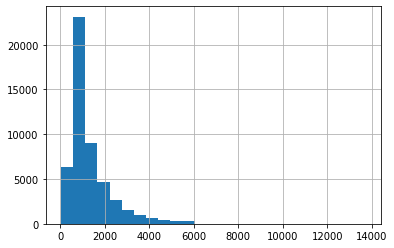

In [33]:
data['length of text'].hist(bins=25)

We can see that most of the review lengths are between 500 and 2000. We will keep that in mind for later.

The Bert tokenizer that we will use after does not recognize emoji, it encodes them with an unknown token. Therefore, we should transform each smiley in the reviews into text. To do that, we will use the emoji librairy.

In [0]:
def emoji_2_text(review):
    return emoji.demojize(review)
data['review']=data['review'].apply(lambda x:emoji_2_text(x))

We then split it so that we can cross-validate our resutls.

In [0]:
df_train, df_test = train_test_split(data, test_size=0.1)
df_val, df_test = train_test_split(df_test, test_size=0.5)

# Tokenizing the reviews with the first 200 tokens.

We need to preprocess the data by tokenizing it, so that it can bu understood by our model. To do that, we're gonna use the pre-trained Bert Tranformer from the transformer librairy.

The max length is the length of the tokenizez sentence. Normally, Bert accept a max length of 512. However, because of memory issues, we are only using 200.
To begin with, we will only use the first 200 hundred tokens, because it seeems logical that the beginning of the review gives the tone of it.

In [0]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

After that, we need to create a Data Loader to use the resulting dataset of our pre-processing.

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df['review'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [12]:
tokenizer = ppb.BertTokenizer.from_pretrained('bert-base-cased')

In [0]:
batch_size = 32
max_len=200

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

Bert is already pre-trained, thus we can use transfer learning so get some results. In this case, we're adding a dropout layer, and a fully-connected with two neurons for our output.

In [0]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = ppb.BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
model = SentimentClassifier(2)
model = model.to(device)

We're gonna try our model on a test batch.

In [0]:
test = next(iter(train_data_loader))

In [0]:
input_ids = test['input_ids'].to(device)
attention_mask = test['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 190])
torch.Size([32, 190])


In [0]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3329, 0.6671],
        [0.4183, 0.5817],
        [0.4476, 0.5524],
        [0.4181, 0.5819],
        [0.3227, 0.6773],
        [0.3827, 0.6173],
        [0.4774, 0.5226],
        [0.4149, 0.5851],
        [0.4016, 0.5984],
        [0.2502, 0.7498],
        [0.3218, 0.6782],
        [0.4558, 0.5442],
        [0.3248, 0.6752],
        [0.4646, 0.5354],
        [0.3817, 0.6183],
        [0.4822, 0.5178],
        [0.5556, 0.4444],
        [0.4348, 0.5652],
        [0.4572, 0.5428],
        [0.4661, 0.5339],
        [0.3521, 0.6479],
        [0.2482, 0.7518],
        [0.3468, 0.6532],
        [0.4242, 0.5758],
        [0.3519, 0.6481],
        [0.4405, 0.5595],
        [0.3864, 0.6136],
        [0.4986, 0.5014],
        [0.3832, 0.6168],
        [0.4369, 0.5631],
        [0.5234, 0.4766],
        [0.4387, 0.5613]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [0]:
test['targets']

tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1])

We can see that on a batch test, the results seem coherent. We will now try to train the pre-trained model, to get the best results possible.

In [0]:
EPOCHS = 2

optimizer = ppb.AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = ppb.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
%%time


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()



Epoch 1/2
----------
Train loss 0.2783853772844968 accuracy 0.8827555555555556
Val   loss 0.24300923085288156 accuracy 0.9012

Epoch 2/2
----------
Train loss 0.14202730469180597 accuracy 0.9499333333333334
Val   loss 0.2819033622553077 accuracy 0.9088

CPU times: user 56min 20s, sys: 35min 21s, total: 1h 31min 42s
Wall time: 1h 32min 20s


The results are actually pretty good on the train and the validation set. Let's see the performance on the test set.

In [22]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9088

The accuracy on the test set is almost the same, we don't have an overfitting problem.

If we wanted to imporve our model, we should firstly set the max_length at 512. However, most of the sentences are longer that that. therefore, we could separate the reviews into parts.

# Aternate way of tokenizing the reviews

The previous solution was not optimal because we only used 200 hundred tokens, and therefore, we lost some information.

My first idea was to separate the reviews into parts of length 200 each, and then feed them into Bert, and then use a layer such as max pooling, or even a LSTM layer to concatenate the results. However, by looking into some research papers, I found a paper, *How to Fine-Tune BERT for Text Classification?* (https://arxiv.org/pdf/1905.05583.pdf), which shows that this is not the most efficient method. Instead, we should take the head and the tail of the review, in order to get the most important information, and that is what I am going to do.

In [0]:
def select(review):
    if len(review)<=200: return review
    else:
        return review[:99]+' '+review[-98:]

In [23]:
df_train['review']=df_train['review'].apply(lambda x:select(x))
df_val['review']=df_val['review'].apply(lambda x:select(x))
df_test['review']=df_test['review'].apply(lambda x:select(x))
len(df_train['review'].iloc[0])   #we should fing a length of 198, because the tokenizer is going to add 2 tokens, the [CLS] token and the [SEP] token

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


198

In [0]:
batch_size = 32
max_len=200

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

In [0]:
model2 = SentimentClassifier(2)
model2 = model.to(device)

In [0]:
EPOCHS = 2

optimizer = ppb.AdamW(model2.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = ppb.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
%%time


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model2,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model2,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

Epoch 1/2
----------
Train loss 0.35626622754881887 accuracy 0.8368888888888889
Val   loss 0.277257391546346 accuracy 0.8748

Epoch 2/2
----------
Train loss 0.18735043215217875 accuracy 0.9262
Val   loss 0.32782580538452427 accuracy 0.8712000000000001

CPU times: user 55min 29s, sys: 33min 29s, total: 1h 28min 59s
Wall time: 1h 29min 11s


In [28]:
test_acc, _ = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8708

The accuracy on the test dataset is a bit lower than the previous model, but this may be because we only trained on 2 epochs. We should try to learn on 10 epochs to really analyze the results. However, for now, we will consider that the first model is better.

# Summarizing each reviews into a summary of length 200

We are still confronted to the problem of taking only 200 tokens.

To solve this issue, we can try to summaryze each reviews into a summary of length 200, and then apply our sentiment analysis model. To summaryze the reviews, we are going to use gensim, a library in python. It may solve our problem, because the summary should contain the most important information.

In [0]:
def summary(review, word_count):
    if len(review)<=200: return review
    elif len(gensim.summarization.textcleaner.clean_text_by_sentences(review))==1:  #if there is only one sentence, gensim.summerize raise a value error. To solve this we are making sure that there are mor tham one sentence.
        return review[:99]+' '+review[-98:]                               # If there is only one sentence we take the beginning and the end of the review as our summary.
    elif len(gensim.summarization.summarize(review, word_count=word_count))==0:
        return review[:99]+' '+review[-98:]
    else:
        return gensim.summarization.summarize(review, word_count=word_count)

We will choose a summary of approximately 45 words, because a word is 5 characters long in average.

In [38]:
df_train['summary']=df_train['review'].apply(lambda r:summary(r.replace('.','. ').replace('<br /><br />','. '), word_count=45))
df_val['summary']=df_val['review'].apply(lambda r:summary(r.replace('.','. ').replace('<br /><br />','. '), word_count=45))
df_test['summary']=df_test['review'].apply(lambda r:summary(r.replace('.','. ').replace('<br /><br />','. '), word_count=45))
df_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,review,length of text,sentiment,summary
35988,this is a really great series. i love the show...,722,1,it has really good humor and shows the realist...
25712,Once again John Madden has given us a magnific...,950,1,"Anyway, Cage was very good in one of his best ..."
13190,"Fame, I think, was the best movie that I have ...",1538,1,"In ways it was funny and dramatic, but that is..."
48898,"Hilarious, Sellers at his funniest ... a shame...",270,1,"Hilarious, Sellers at his funniest .\na shame ..."
30067,"I happened to catch this on TV, and wanted to ...",836,0,"First, if James Belushi is the lead actor in a..."


We now have two change our dataset class, and our dataloader in order to use the summaries instead of the reviews.

In [0]:
class GPReviewDataset(Dataset):

  def __init__(self, summaries, targets, tokenizer, max_len):
    self.summaries = summaries
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.summaries)
  
  def __getitem__(self, item):
    summary = str(self.summaries[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      summary,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    summaries=df['summary'].to_numpy(),
    targets=df['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
batch_size = 32
max_len=200

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

We keep the same functions, we just change the data loader. Thus, we can now easily train the data on the summaries instead of the reviews.

In [0]:
model_sum = SentimentClassifier(2)
model_sum = model.to(device)

In [0]:
EPOCHS = 2

optimizer = ppb.AdamW(model_sum.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = ppb.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [43]:
%%time


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model_sum,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model_sum,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()



Epoch 1/2
----------
Train loss 0.41706442546467454 accuracy 0.8433333333333334
Val   loss 0.5001490199113194 accuracy 0.8260000000000001

Epoch 2/2
----------
Train loss 0.41551492499040643 accuracy 0.8434
Val   loss 0.5001490199113194 accuracy 0.8260000000000001

CPU times: user 55min 11s, sys: 34min 40s, total: 1h 29min 52s
Wall time: 1h 30min 8s


In [45]:
test_acc, _ = eval_model(
  model_sum,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8316

The accuray is a bit lower than the previous model. One of the explanantion could be that the first words contains the sentiment of the reviews and may not be contained in the summary.

# Real data inference

In order to try the best model with real life data, I went on the IMDB website and I selected 2 good reviews and 2 bad reviews for three movies: Jurassic World, Inception and Uncut Gems. Let's see how the model works with this data.

We will try it with our first model, which has the best accuracy on the test dataset.

In [0]:
review1="Is a solid movie and it holds itself as a trilling experience for everyone. Yes, people from the original cast are not there, however there is actually not a logical reason in the time line to make them go back. Taking out this little detail, the acting is amazing and Chris Pratt holds amazingly as a main character again . Animations are better than ever and the story line even if a little prematurely developed is exciting and looks to reward the new audience as well as the hard on fans. Overall is a great movie which promise enjoyment. I loved it and I will recommend it for everyone that is a fan and for the ones that just want to see a movie that will print a smile at the end."
review2="Of course it isn't powerful like the first one, but a super great movie."
review3="Everything about this movie is top notch. The cast, directing, and plot all breed depth and endless layers of complexity."
review4="An impressive detail seen elsewhere.If you pull out the first letters of the main characters' names (Dom, Robert, Eames, Arther, Mal, Saito), they make up the word 'dreams'.Then I found out that the movie was really full of secrets."
review5="The fact that this film didn't even get any Oscar nominations is a crime. It's a crazy, anxiety-inducing roller coaster ride, and the rewatchability is insane."
review6="I dont know where the cliche over played Adam Sandler came up with this acting but.... much respect to him for a great portrayl of his character.. This movie is amazing and deserves to be watched and rewatched.. If you gamble or enjoy the idea of a risk taker in financial means.. you will enjoy this soo much.. The only reason im writing is because woooww finally Adam. S actually did the job I wished he could do in all of his movies, he went out of his comfort zone in this and it shows. Much respect to him and the beautiful duo from Good Time that made this happen.."
review7="This movie sucked, it was horrible. It has the most confusing story and the original Jurassic park was so much better. I wish it was directed by somebody else because the person who directed this sucked at it. I'm lucky I didn't see this in theaters because I would've wasted my money. Please take my advice and don't watch it because the movie is boring and terrible."
review8="Almost every idea of this movie 'Jurassic World'  is copied from its 1993 original Jurassic Park. Even the characters are the same: one male protagonist, one female protagonist, two children and some stupid guys. It is a shame that today filmmakers have lost their pioneering spirit and just rely on sequel, reboot or remake of existing intellectual properties for cash grab purposes."
review9="I think all the other 1 star voters stated exactly how I feel about this movie. I have never felt motivated to write a movie review in my life. This was one of the worst movies I've ever seen! My favorite movie reviewer gave it 4/4 stars. I am baffled - - I really feel like I'm missing something... although there seem to be many out there that have the same thoughts I do. Thanks for confirming my opinions! I could tell within five minutes of the movie that I was not going to like it and that I wouldn't be able to follow it. Should have walked out then. I am the most sympathetic person to characters in a movie. I was amazed that I couldn't care less if all of the main characters were shot dead. There was zero character development. I felt a bit nauseous from all of the action and I really coudn't tell what was going on a lot of the time."
review10="Frankly, I don't see how all these people vote for 8. Inception is such a claustrophobic and overwhelming movie. The whole movie is extremely boring and isn't containing any funny moment. Yes, we are all know that this is not a comic. But the movie is going so serious when there's nothing to be serious about."
review11="This movie is a headache. I don't understand the constant, terrible background music."
review12="This movie was brutal if there is one word to describe it. The score and music was horrible didn't match or go with the movie already making you not invested... from a terrible script that had some ideas but never latched onto anything but bad acting, screaming, and unwanted sex scenes that will make you cringe. An ending that attempted to save this disaster but was too little too late. Awful awful film that should have zero praise just because it is an indie pic."

In [25]:
sentiment=[1,1,1,1,1,1,0,0,0,0,0,0]
reviews=[review1,review2,review3,review4,review5,review6,review7,review8,review9,review10,review11,review12]
df_real=pd.DataFrame({'review':reviews,'sentiment':sentiment})
df_real.head()

,review,sentiment
0,Is a solid movie and it holds itself as a tril...,1
1,Of course it isn't powerful like the first one...,1
2,Everything about this movie is top notch. The ...,1
3,An impressive detail seen elsewhere.If you pul...,1
4,The fact that this film didn't even get any Os...,1


In [0]:
real_data_loader = create_data_loader(df_real, tokenizer, max_len, batch_size)

In [36]:
real_acc, _ = eval_model(
  model,
  real_data_loader,
  loss_fn,
  device,
  len(df_real)
)

real_acc.item()

1.0

The accuracy is one, which means that every review was correctly labelled. This shows that our model works great with real-world data. The perfect accuracy is due to the fact that I chose the best 2 reviews and the worst reviews for each movie, therefore, the reviews were unambiguously positive or negative.